### YPLL

In [1]:
setwd("C:\\Users\\SROY\\Desktop\\Courses\\Applied Stats\\Project")
rm(list=ls())
seedVal = 17869
options(warn=-1)
options(scipen=999)

In [2]:
# Libraries
library(ggplot2)
library(ggcorrplot)
library(dummies)
library(rms)
library(lmtest)

dummies-1.5.6 provided by Decision Patterns

Loading required package: Hmisc
Loading required package: lattice
Loading required package: survival
Loading required package: Formula

Attaching package: 'Hmisc'

The following objects are masked from 'package:base':

    format.pval, round.POSIXt, trunc.POSIXt, units

Loading required package: SparseM

Attaching package: 'SparseM'

The following object is masked from 'package:base':

    backsolve

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Attaching package: 'lmtest'

The following object is masked from 'package:rms':

    lrtest



In [3]:
measures <- read.csv2("additional_measures_cleaned.csv", header = TRUE, sep = ',')
ypll <- read.csv2("ypll.csv", header = TRUE, sep = ',')

In [4]:
head(measures)

FIPS,State,County,Population,X..18,X65.and.over,African.American,Female,Rural,X.Diabetes,HIV.rate,Physical.Inactivity,mental.health.provider.rate,median.household.income,X..high.housing.costs,X..Free.lunch,X..child.Illiteracy,X..Drive.Alone
1000,Alabama,,4708708,23.9,13.8,26.1,51.6,44.6,12,NA,31,20,42586,30,51,14.8,84
1001,Alabama,Autauga,50756,27.8,11.6,18.4,51.4,44.8,11,170,33,2,51622,25,29,12.7,86
1003,Alabama,Baldwin,179878,23.1,17,10,51,54.2,10,176,25,17,51957,29,29,10.6,83
1005,Alabama,Barbour,29737,22.3,13.8,46.6,46.8,71.5,14,331,35,7,30896,36,65,23.2,82
1007,Alabama,Bibb,21587,23.3,13.5,22.3,48,81.5,11,90,37,0,41076,18,48,17.5,83
1009,Alabama,Blount,58345,24.2,14.7,2.1,50.2,91,11,66,35,2,46086,21,37,13.9,80


In [5]:
head(ypll)

FIPS,State,County,Unreliable,YPLL.Rate
1000,Alabama,,,10189
1001,Alabama,Autauga,,9967
1003,Alabama,Baldwin,,8322
1005,Alabama,Barbour,,9559
1007,Alabama,Bibb,,13283
1009,Alabama,Blount,,8475


In [6]:
df <- merge(x = ypll, y = measures, by.x = c("FIPS"), by.y = c("FIPS"))

In [7]:
apply(df, 2, function(x) length(which(x == "" | is.na(x) | x == "NA")))

FIPS                     State.x 
                          0                           0 
                   County.x                  Unreliable 
                         51                        2996 
                  YPLL.Rate                     State.y 
                         95                           0 
                   County.y                  Population 
                         51                           0 
                      X..18                X65.and.over 
                          0                           0 
           African.American                      Female 
                          0                           0 
                      Rural                  X.Diabetes 
                          1                           0 
                   HIV.rate         Physical.Inactivity 
                        962                           0 
mental.health.provider.rate     median.household.income 
                          0                           1 
      X..high.housing.costs               X..Free.lunch 
                          0                          19 
        X..child.Illiteracy              X..Drive.Alone 
                          6                           0

In [8]:
# remove records that are unreliable
df <- df[df$Unreliable != 'x',names(df) != 'Unreliable']
# Remove cumulative records
df <- df[df$County.x != '',]
# Remove missing YPLL rate as it does not add value and 
# doesn't make sense to impute it as it is the target variable
df <- df[!is.na(df$YPLL.Rate),]
# Remove missing Rural, X.free.lunch and X..chile.Illiteracy as they are few
# removing 1 rural also removes free lunch and child illiteracy 
df <- df[!df$Rural == '',]
df <- df[!df$X..child.Illiteracy == '',]
df <- df[!is.na(df$X..Free.lunch),]

In [9]:
apply(df, 2, function(x) length(which(x == "" | is.na(x) | x == "NA")))

FIPS                     State.x 
                          0                           0 
                   County.x                   YPLL.Rate 
                          0                           0 
                    State.y                    County.y 
                          0                           0 
                 Population                       X..18 
                          0                           0 
               X65.and.over            African.American 
                          0                           0 
                     Female                       Rural 
                          0                           0 
                 X.Diabetes                    HIV.rate 
                          0                         625 
        Physical.Inactivity mental.health.provider.rate 
                          0                           0 
    median.household.income       X..high.housing.costs 
                          0                           0 
              X..Free.lunch         X..child.Illiteracy 
                          0                           0 
             X..Drive.Alone 
                          0

In [10]:
# HIV rate is an important predictor. but 22% values are missing
# so it is difficult to impute
# we can bucket it into categories
HIVRate <- df[!is.na(df$HIV.rate),'HIV.rate']
range(HIVRate)
quantile(HIVRate)

df$HIV <- cut(df$HIV.rate, breaks = c(-Inf, 57, 98, 194, Inf), 
              labels = c("VeryLow","Low","High","VeryHigh"))
df$HIV <- as.character(df$HIV)
df[is.na(df$HIV),'HIV'] <- 'NotAvail'
df$HIV <- as.factor(df$HIV)

[1]   13 4534

0%  25%  50%  75% 100% 
  13   57   98  194 4534

In [11]:
# Remove irrelevant columns
names(df)
excludeList <- c("FIPS", "State.x", "State.y", "County.x", "County.y", "HIV.rate")
includeList <- names(df[!names(df) %in% c(excludeList)])
df <- df[,includeList]

[1] "FIPS"                        "State.x"                    
 [3] "County.x"                    "YPLL.Rate"                  
 [5] "State.y"                     "County.y"                   
 [7] "Population"                  "X..18"                      
 [9] "X65.and.over"                "African.American"           
[11] "Female"                      "Rural"                      
[13] "X.Diabetes"                  "HIV.rate"                   
[15] "Physical.Inactivity"         "mental.health.provider.rate"
[17] "median.household.income"     "X..high.housing.costs"      
[19] "X..Free.lunch"               "X..child.Illiteracy"        
[21] "X..Drive.Alone"              "HIV"

In [12]:
# Change factors to numeric
df$X..18 <- as.numeric(as.character(df$X..18))
df$X65.and.over <- as.numeric(as.character(df$X65.and.over))
df$African.American <- as.numeric(as.character(df$African.American))
df$Female <- as.numeric(as.character(df$Female))
df$Rural <- as.numeric(as.character(df$Rural))
df$X..child.Illiteracy <- as.numeric(as.character(df$X..child.Illiteracy))
str(df)
summary(df)

'data.frame':	2834 obs. of  16 variables:
 $ YPLL.Rate                  : int  9967 8322 9559 13283 8475 15433 12652 11720 11319 11753 ...
 $ Population                 : int  50756 179878 29737 21587 58345 10985 19964 114081 34320 24448 ...
 $ X..18                      : num  27.8 23.1 22.3 23.3 24.2 24.6 24.8 23.4 22.5 20.9 ...
 $ X65.and.over               : num  11.6 17 13.8 13.5 14.7 10.8 16.2 15 16.8 18.6 ...
 $ African.American           : num  18.4 10 46.6 22.3 2.1 68.2 41.9 20 37.8 5.6 ...
 $ Female                     : num  51.4 51 46.8 48 50.2 44.5 52.9 52.1 52.6 51.4 ...
 $ Rural                      : num  44.8 54.2 71.5 81.5 91 64.7 74.8 31 49.8 100 ...
 $ X.Diabetes                 : int  11 10 14 11 11 15 15 15 16 14 ...
 $ Physical.Inactivity        : int  33 25 35 37 35 32 35 32 36 37 ...
 $ mental.health.provider.rate: int  2 17 7 0 2 0 5 11 3 0 ...
 $ median.household.income    : int  51622 51957 30896 41076 46086 26980 31449 39997 35614 38028 ...
 $ X..high.housi

   YPLL.Rate       Population          X..18        X65.and.over  
 Min.   : 3275   Min.   :   1485   Min.   :11.30   Min.   : 2.60  
 1st Qu.: 6696   1st Qu.:  14371   1st Qu.:21.60   1st Qu.:12.70  
 Median : 8146   Median :  29840   Median :23.50   Median :15.00  
 Mean   : 8461   Mean   : 107552   Mean   :23.64   Mean   :15.18  
 3rd Qu.: 9934   3rd Qu.:  75279   3rd Qu.:25.30   3rd Qu.:17.30  
 Max.   :24829   Max.   :9848011   Max.   :40.50   Max.   :34.30  
 African.American     Female          Rural          X.Diabetes   
 Min.   : 0.000   Min.   :25.10   Min.   :  0.00   Min.   : 3.00  
 1st Qu.: 0.900   1st Qu.:49.80   1st Qu.: 33.50   1st Qu.: 9.00  
 Median : 2.900   Median :50.60   Median : 56.85   Median :10.00  
 Mean   : 9.867   Mean   :50.23   Mean   : 56.09   Mean   :10.01  
 3rd Qu.:11.800   3rd Qu.:51.30   3rd Qu.: 78.97   3rd Qu.:11.00  
 Max.   :86.300   Max.   :58.00   Max.   :100.00   Max.   :18.00  
 Physical.Inactivity mental.health.provider.rate median.househ

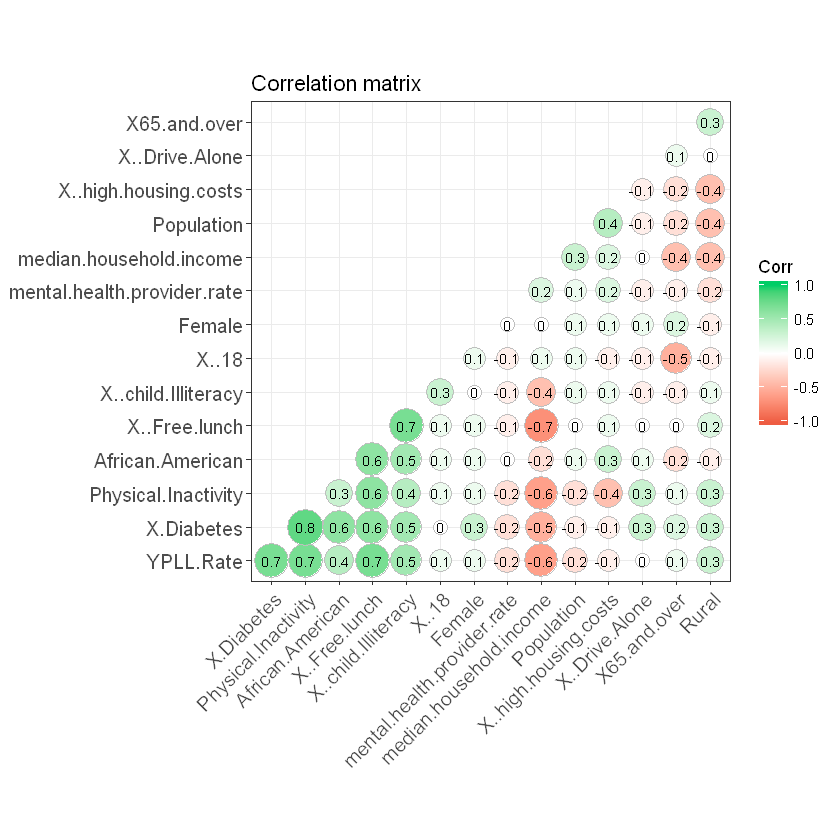

In [13]:
# select numeric columns
numVars <- names(which(sapply(df, is.numeric)))
# correlation matrix
corr <- round(cor(df[,numVars]), 1)
ggcorrplot(corr, hc.order = TRUE, 
           type = "lower", 
           lab = TRUE, 
           lab_size = 3, 
           method="circle", 
           colors = c("tomato2", "white", "springgreen3"), 
           title="Correlation matrix", 
           ggtheme=theme_bw)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


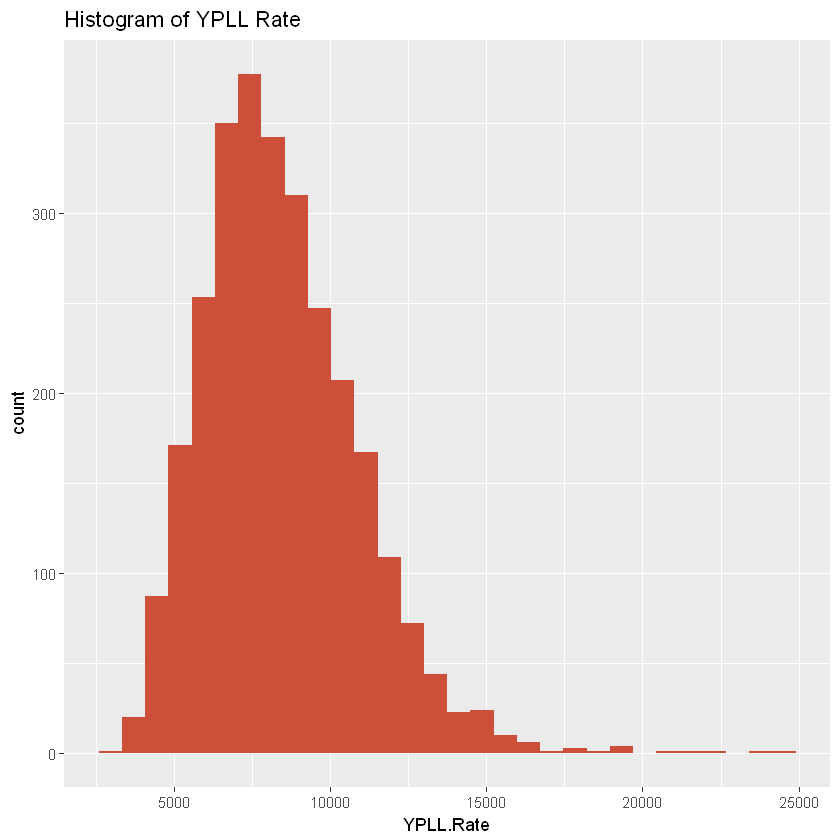

In [14]:
# Histogram
ggplot(df, aes(YPLL.Rate)) +  
  geom_histogram(fill="tomato3") +  
  labs(title="Histogram of YPLL Rate")
# not highly skewed. No need to scale. We can verify it later.

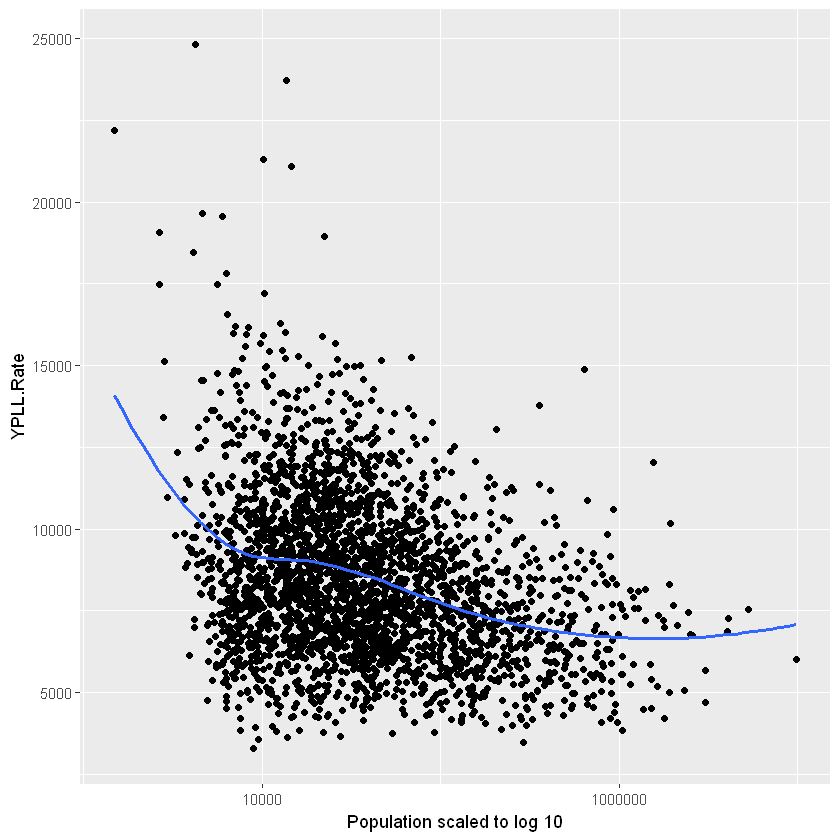

In [15]:
# Scatterplot
ggplot(df, aes(x=Population, y=YPLL.Rate)) + 
  geom_point() + 
  geom_smooth(method="loess", se=F) + scale_x_log10() +
  labs(x="Population scaled to log 10")
# Outliers

In [16]:
# Dummy HIV variable
df <- cbind(df, dummy(df$HIV))
df <- df[,!names(df) %in% "HIV"]

In [17]:
# Assign x y vars
yVar <- "YPLL.Rate"
xVars <- names(df[!names(df) %in% c(yVar)])

createModelFormula <- function(yVar, xVars, includeIntercept = TRUE){
  if(includeIntercept){
    modelForm <- as.formula(paste(yVar, "~", paste(xVars, collapse = '+ ')))
  } else {
    modelForm <- as.formula(paste(yVar, "~", paste(xVars, collapse = '+ '), -1))
  }
  return(modelForm)
}

YPLL.Rate ~ Population + X..18 + X65.and.over + African.American + 
    Female + Rural + X.Diabetes + Physical.Inactivity + mental.health.provider.rate + 
    median.household.income + X..high.housing.costs + X..Free.lunch + 
    X..child.Illiteracy + X..Drive.Alone + NAHigh + NALow + NANotAvail + 
    NAVeryHigh + NAVeryLow - 1
<environment: 0x000000001af7dbd0>


Call:
lm(formula = modelForm, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-5076.9  -833.8   -95.6   705.1 11064.9 

Coefficients:
                                 Estimate    Std. Error t value
Population                    -0.00021906    0.00009676  -2.264
X..18                         87.86276811   11.97182726   7.339
X65.and.over                 -20.18209330   10.94826598  -1.843
African.American              -2.03624212    3.45369035  -0.590
Female                        -5.59661428   15.40356529  -0.363
Rural                          5.39630494    1.21619807   4.437
X.Diabetes                   307.54548665   26.33322345  11.679
Physical.Inactivity           83.59794555    9.53463728   8.768
mental.health.provider.rate   -0.99053873    0.44923676  -2.205
median.household.income       -0.04992777    0.00426563 -11.705
X..high.housing.costs          3.55465583    5.78602292   0.614
X..Free.lunch                 46.95881427    3.30803546  14.195
X..child.Illitera

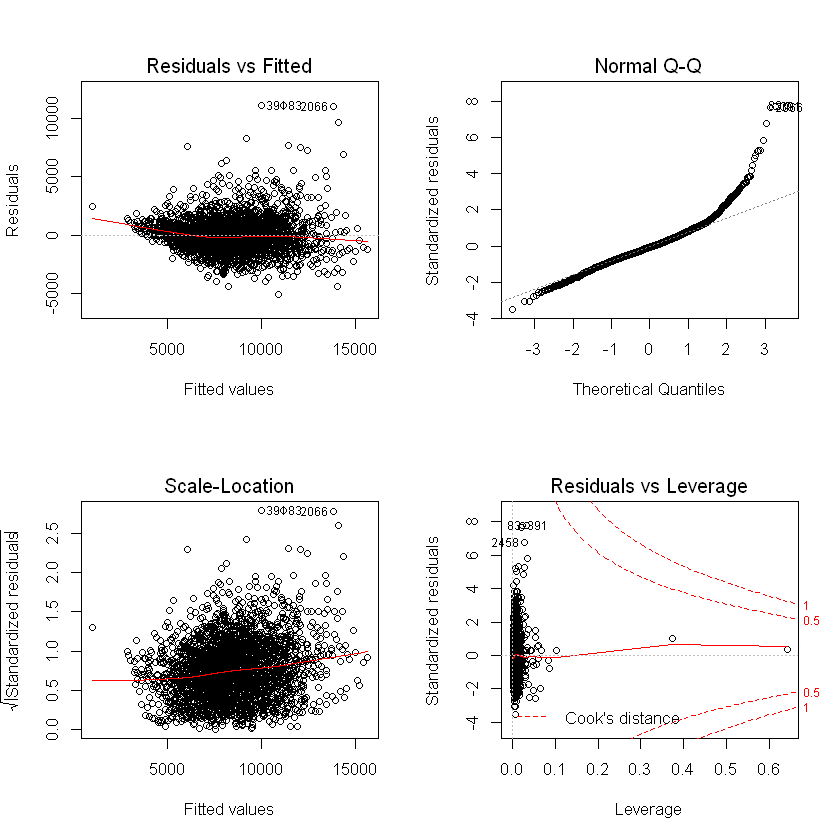

In [18]:
# Fit linear model with all variables
modelForm <- createModelFormula(yVar = yVar, xVars = xVars, includeIntercept = FALSE)
modelForm
lm.1 <- lm(modelForm, data = df)
summary(lm.1)
# Residual analysis:
par(mfrow = c(2, 2))
plot(lm.1)

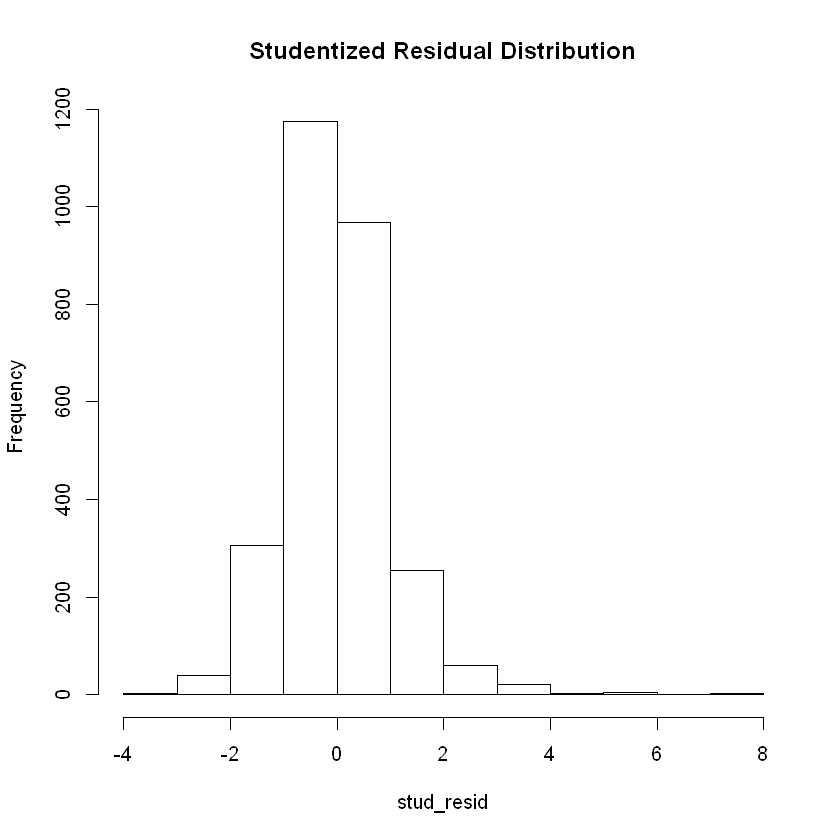

In [19]:
# Remove outliers using studentized residual
stud_resid <- rstudent(lm.1)
hist(stud_resid, main = "Studentized Residual Distribution")

[1] 133

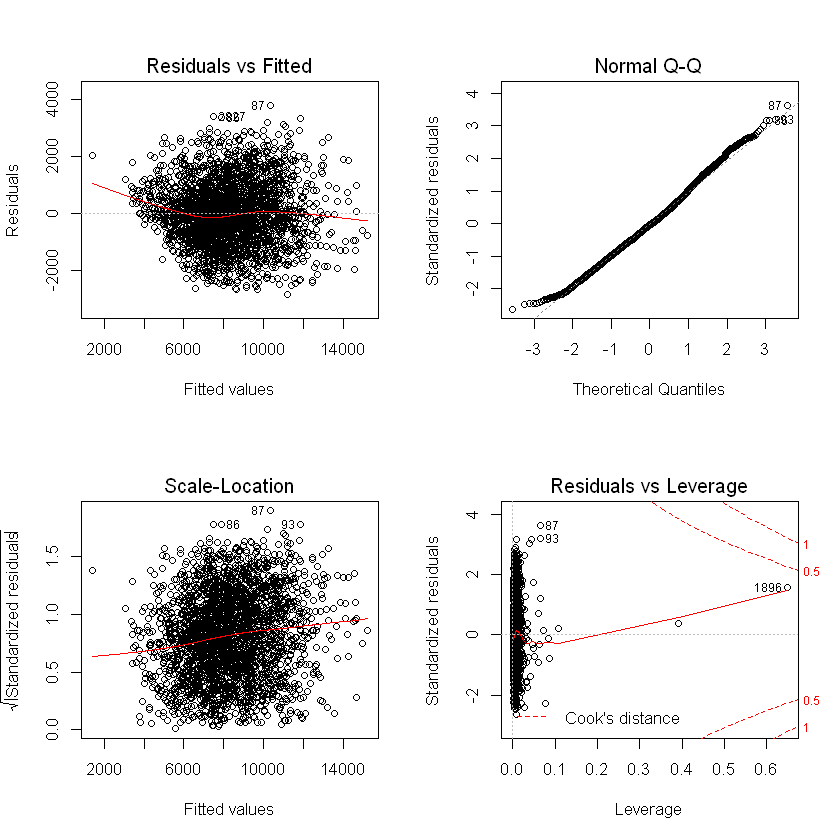

In [20]:
# Exclude studentized residual > 3
rmv_stud_resid <- stud_resid[abs(stud_resid) > 2]
length(rmv_stud_resid)
# Exclude outliers
df_exc_out <- df[!row.names(df) %in% names(rmv_stud_resid),]
lm.2 <- lm(modelForm, data = df_exc_out)
# Residual analysis:
par(mfrow = c(2, 2))
plot(lm.2)

In [21]:
# Reset rownames
rownames(df) <- seq(length=nrow(df))
rownames(df_exc_out) <- seq(length=nrow(df_exc_out))

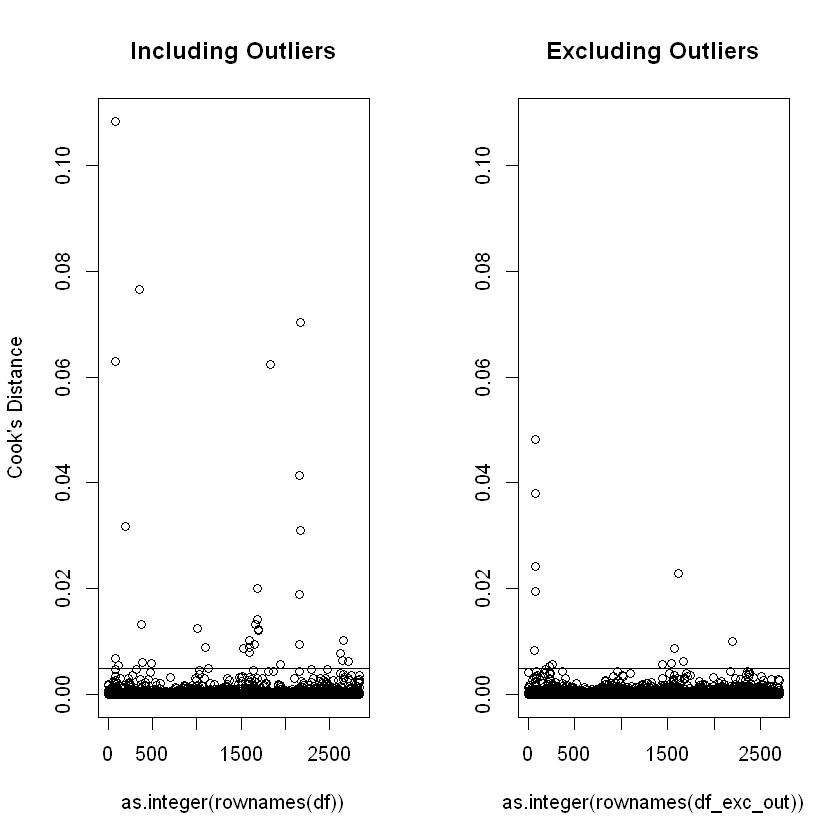

In [22]:
# Remove influential observations using Cook's D
cook_simple = cooks.distance(lm.1)
cook_exc_outliers = cooks.distance(lm.2)
# identify Cook's D values > 4/(n-k-1) 
cutoff <- 4/((nrow(df_exc_out)-length(lm.2$coefficients)-2))
par(mfrow = c(1, 2))
plot(as.integer(rownames(df)), cook_simple, main = "Including Outliers", 
     ylab = "Cook's Distance", ylim = c(0, max(cook_simple)))
abline(h = 0.005)
plot(as.integer(rownames(df_exc_out)), cook_exc_outliers, main = "Excluding Outliers", 
     ylab = "", ylim = c(0, max(cook_simple)))
abline(h = 0.005)

[1] 134

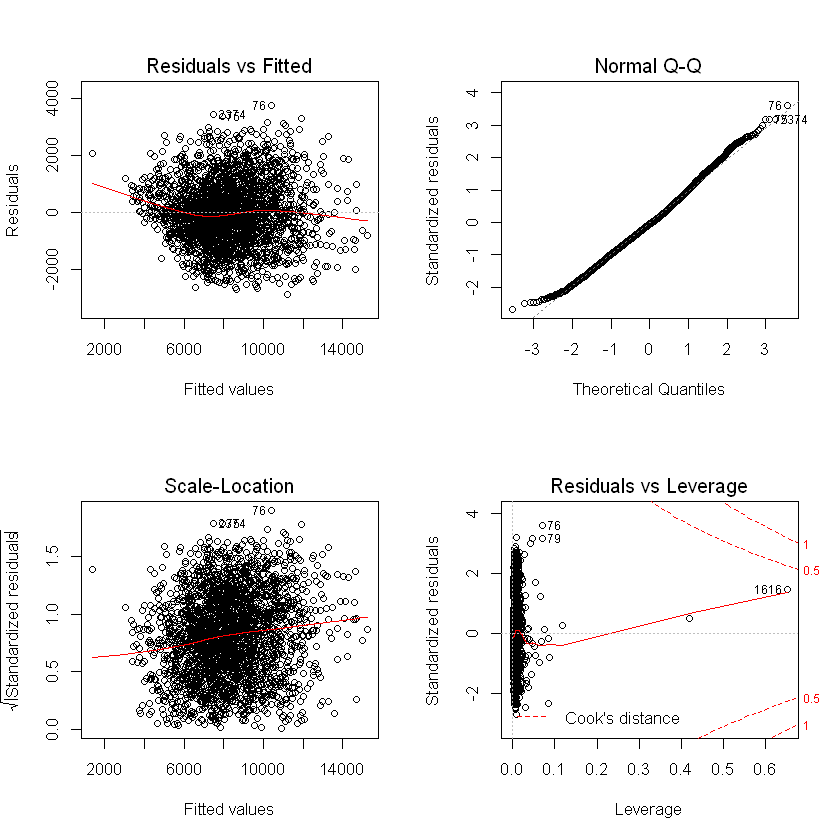

In [23]:
# Find Cook on top of data without outliers
rmv_cook_inf <- cook_exc_outliers[cook_exc_outliers > cutoff]
length(rmv_cook_inf)

# Exclude Influence
df_exc_inf <- df_exc_out[!row.names(df_exc_out) %in% names(rmv_cook_inf),]
lm.3 <- lm(modelForm, data = df_exc_inf)
# Residual analysis:
par(mfrow = c(2, 2))
plot(lm.3)

'data.frame':	2590 obs. of  20 variables:
 $ YPLL.Rate                  : int  9967 8322 9559 8475 15433 12652 11319 11753 12243 10116 ...
 $ Population                 : int  50756 179878 29737 58345 10985 19964 34320 24448 42971 13990 ...
 $ X..18                      : num  27.8 23.1 22.3 24.2 24.6 24.8 22.5 20.9 24.5 23.3 ...
 $ X65.and.over               : num  11.6 17 13.8 14.7 10.8 16.2 16.8 18.6 13.4 17.5 ...
 $ African.American           : num  18.4 10 46.6 2.1 68.2 41.9 37.8 5.6 11.4 43.6 ...
 $ Female                     : num  51.4 51 46.8 50.2 44.5 52.9 52.6 51.4 50.3 53.1 ...
 $ Rural                      : num  44.8 54.2 71.5 91 64.7 74.8 49.8 100 88 100 ...
 $ X.Diabetes                 : int  11 10 14 11 15 15 16 14 10 15 ...
 $ Physical.Inactivity        : int  33 25 35 35 32 35 36 37 32 34 ...
 $ mental.health.provider.rate: int  2 17 7 2 0 5 3 0 2 0 ...
 $ median.household.income    : int  51622 51957 30896 46086 26980 31449 35614 38028 40292 30728 ...
 $ X..high.ho

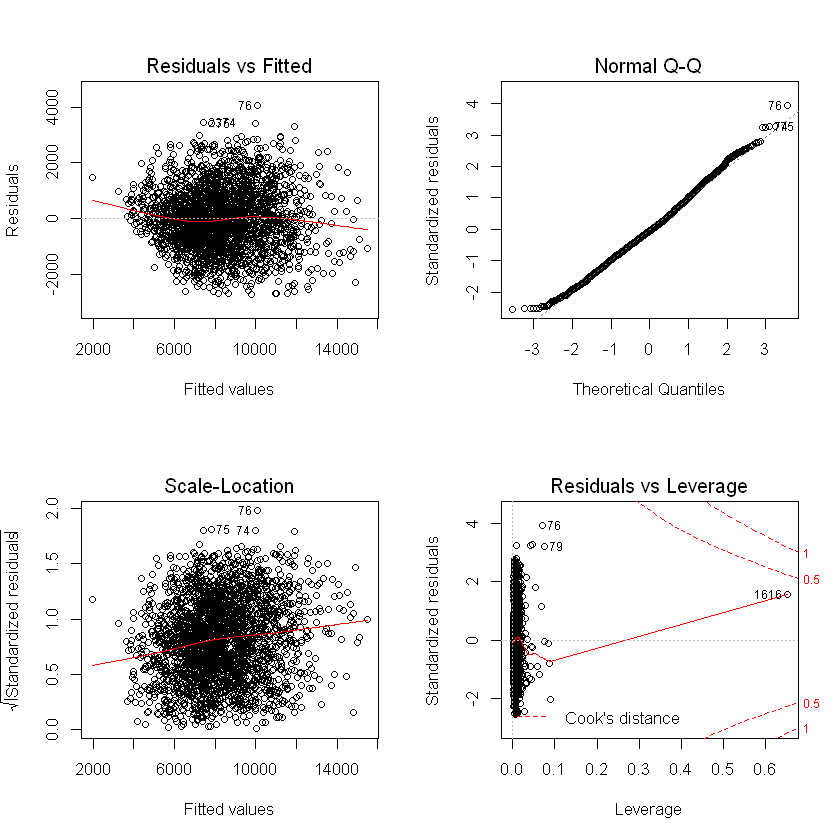

In [24]:
# Scale values to reduce Heteroskedasticity
str(df_exc_inf)
df_exc_scalex <- df_exc_inf
# We can scale only x variables to ln (Population and median.household.income) and verify
df_exc_scalex$Population <- log(df_exc_scalex$Population, exp(1))
df_exc_scalex$median.household.income <- log(df_exc_scalex$median.household.income, exp(1))
lm.4 <- lm(modelForm, data = df_exc_scalex)
# Residual analysis:
par(mfrow = c(2, 2))
plot(lm.4)

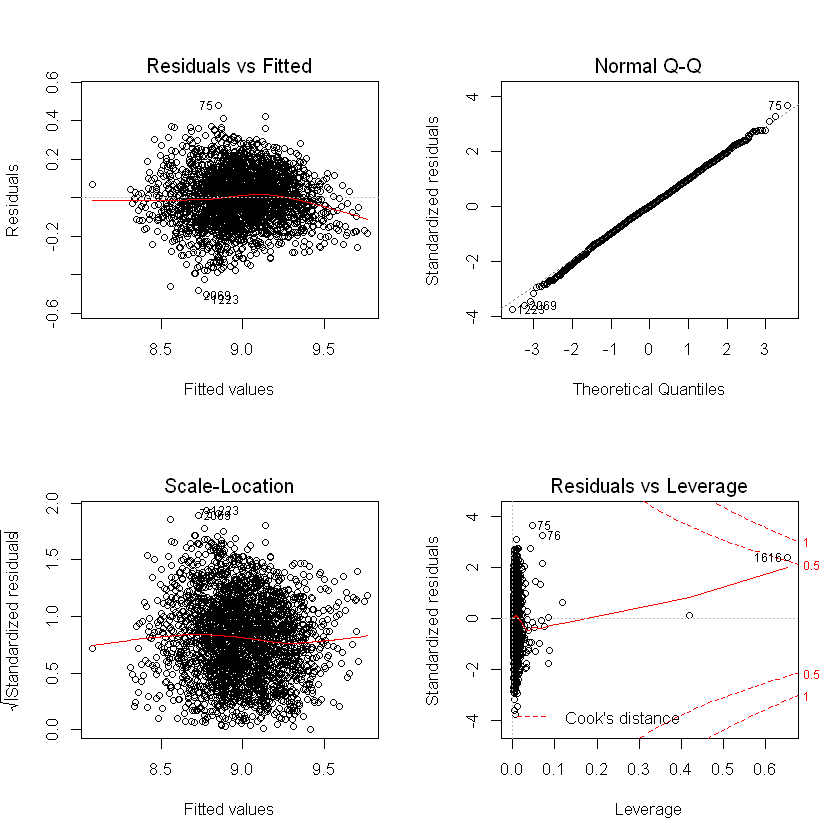

In [25]:
# We now can scale only y to ln (YPLL.Rate) and verify
df_exc_scaley <- df_exc_inf
df_exc_scaley$YPLL.Rate <- log(df_exc_scaley$YPLL.Rate, exp(1))
lm.5 <- lm(modelForm, data = df_exc_scaley)
# Residual analysis:
par(mfrow = c(2, 2))
plot(lm.5) 

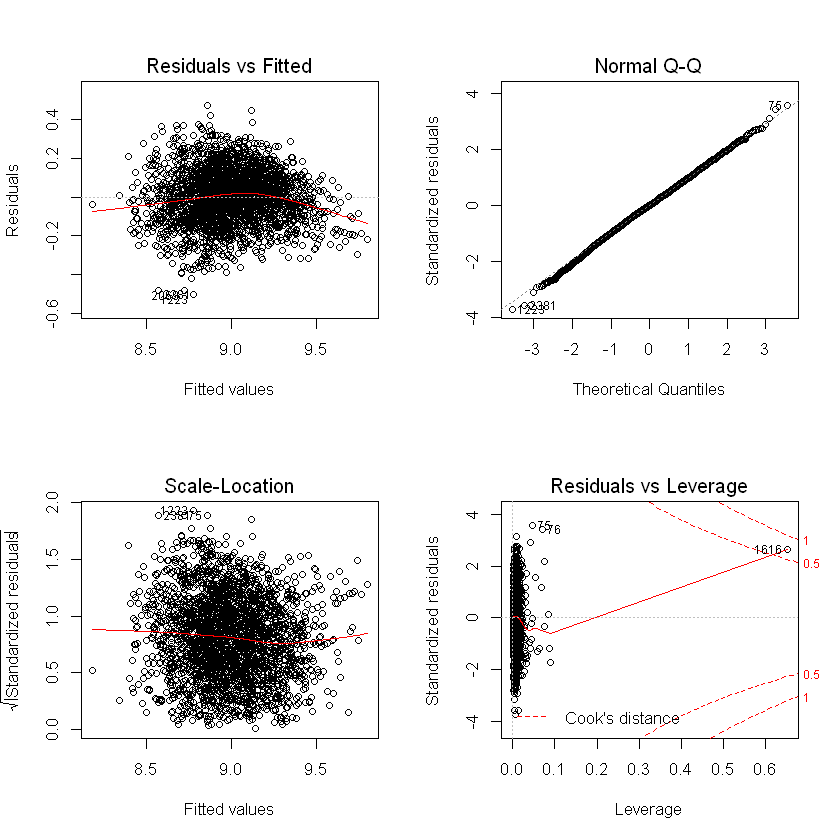

In [26]:
# We now can scale both x and y to ln and verify
df_exc_scalexy <- df_exc_inf
df_exc_scalexy$Population <- log(df_exc_scalexy$Population, exp(1))
df_exc_scalexy$median.household.income <- log(df_exc_scalexy$median.household.income, exp(1))
df_exc_scalexy$YPLL.Rate <- log(df_exc_scalexy$YPLL.Rate, exp(1))
lm.6 <- lm(modelForm, data = df_exc_scalexy)
# Residual analysis:
par(mfrow = c(2, 2))
plot(lm.6) 

Start:  AIC=-10380.96
YPLL.Rate ~ Population + X..18 + X65.and.over + African.American + 
    Female + Rural + X.Diabetes + Physical.Inactivity + mental.health.provider.rate + 
    median.household.income + X..high.housing.costs + X..Free.lunch + 
    X..child.Illiteracy + X..Drive.Alone + NAHigh + NALow + NANotAvail + 
    NAVeryHigh + NAVeryLow - 1

                              Df Sum of Sq     RSS      AIC
- X..high.housing.costs        1     0.003  46.372 -10382.8
- X65.and.over                 1     0.008  46.378 -10382.5
- Female                       1     0.018  46.387 -10382.0
<none>                                      46.370 -10381.0
- Population                   1     0.043  46.412 -10380.6
- African.American             1     0.054  46.423 -10380.0
- X..Drive.Alone               1     0.205  46.575 -10371.6
- Rural                        1     0.394  46.763 -10361.1
- mental.health.provider.rate  1     0.407  46.777 -10360.3
- X..child.Illiteracy          1     0.606  46

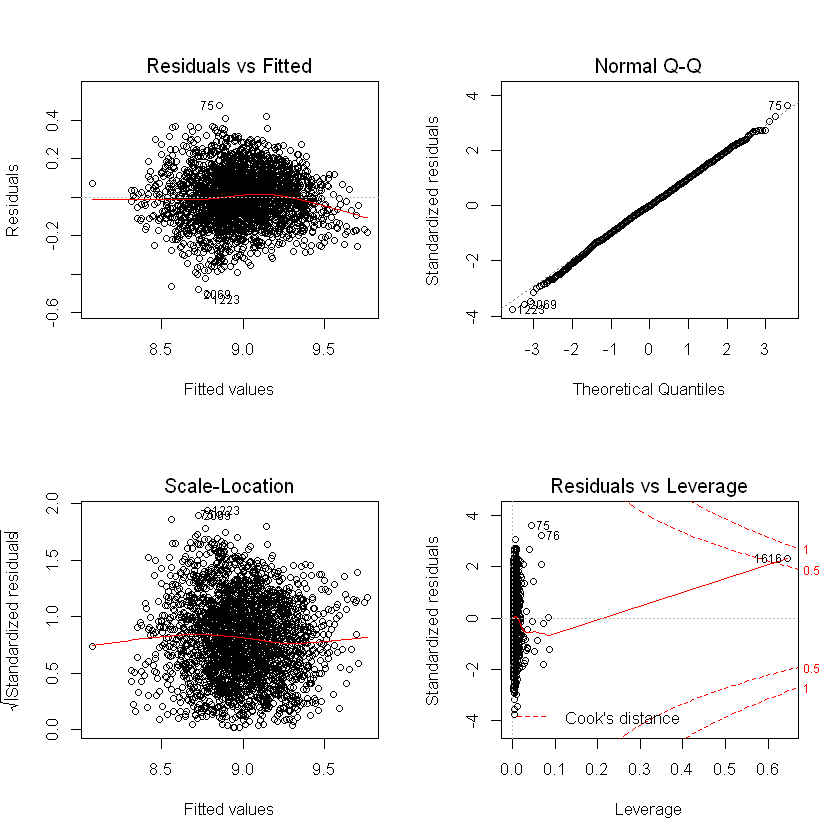

In [27]:
# Test stepwise
lm.7 <- step(lm.5, direction="both")
# Residual analysis:
par(mfrow = c(2, 2))
plot(lm.7)

In [28]:
# We now know model 5 is the best. But does step wise improve model 5?
# Compare lm 7 with lm 5 as it is built on top of it.
# Reduction in the residual sum of squares are statistically significant or not)
anova(lm.5,lm.7, test="Chisq")

Res.Df,RSS,Df,Sum of Sq,Pr(>Chi)
2571,46.36974,NA,NA,NA
2575,46.44811,-4,-0.07836842,0.3613009


In [29]:
# We choose model 7 as the best model as it gives the same performance with less features
summary(lm.5)


Call:
lm(formula = modelForm, data = df_exc_scaley)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.50292 -0.08683 -0.00025  0.08773  0.47830 

Coefficients:
                                   Estimate      Std. Error t value
Population                  -0.000000014621  0.000000009516  -1.537
X..18                        0.007455353141  0.001203643744   6.194
X65.and.over                 0.000721974657  0.001087763881   0.664
African.American            -0.000597328257  0.000346125008  -1.726
Female                       0.001522529066  0.001535360399   0.992
Rural                        0.000559322143  0.000119705511   4.672
X.Diabetes                   0.028850318830  0.002629021647  10.974
Physical.Inactivity          0.010792180888  0.000936164133  11.528
mental.health.provider.rate -0.000199944583  0.000042080099  -4.752
median.household.income     -0.000006478880  0.000000417052 -15.535
X..high.housing.costs        0.000214736544  0.000570275586   0.377
X..Free.lunc

In [30]:
summary(lm.7)


Call:
lm(formula = YPLL.Rate ~ X..18 + African.American + Rural + X.Diabetes + 
    Physical.Inactivity + mental.health.provider.rate + median.household.income + 
    X..Free.lunch + X..child.Illiteracy + X..Drive.Alone + NAHigh + 
    NALow + NANotAvail + NAVeryHigh + NAVeryLow - 1, data = df_exc_scaley)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.50477 -0.08715 -0.00027  0.08895  0.47497 

Coefficients:
                                 Estimate    Std. Error t value
X..18                        0.0073447309  0.0009729181   7.549
African.American            -0.0005568442  0.0003286073  -1.695
Rural                        0.0005710608  0.0001119566   5.101
X.Diabetes                   0.0301097917  0.0024389582  12.345
Physical.Inactivity          0.0105785387  0.0008826982  11.984
mental.health.provider.rate -0.0001973440  0.0000418156  -4.719
median.household.income     -0.0000066828  0.0000003978 -16.801
X..Free.lunch                0.0049587220  0.0003231683  15.3